In [1]:
!pip install fiftyone

In [2]:
!wandb login

wandb: Currently logged in as: matthiascr (matthiascr-hpi-team) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [3]:
import fiftyone as fo
from fiftyone.utils.huggingface import load_from_hub
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision.transforms.v2 as transforms
from torch.utils.data import DataLoader
import wandb


import sys
from pathlib import Path

project_root = Path("..").resolve()
sys.path.append(str(project_root))
from src import datasets
from src import training
from src import visualization
from src import models


/home/matthias/miniconda3/envs/CompVision/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load Data

In [5]:
# hyperparameters will be the same for all experiments to make them comparable
IMG_SIZE = 64
BATCH_SIZE = 32
EPOCHS = 20

START_LR = 1e-3
END_LR = 1e-6

In [6]:
# load fiftyone dataset from huggingface
dataset = load_from_hub(
    "MatthiasCr/multimodal-shapes-subset", 
    name="multimodal-shapes-subset",
    # fewer workers and greater batch size to hopefully avoid getting rate limited
    num_workers=2,
    batch_size=1000,
    overwrite=True,
)

Loading dataset
Importing samples...
 100% |███████████████| 4000/4000 [52.3ms elapsed, 0s remaining, 76.4K samples/s]  


In [7]:
img_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
])

train_dataset = datasets.MultimodalDataset(dataset, "train", img_transforms)
val_dataset = datasets.MultimodalDataset(dataset, "val", img_transforms)

# use generator with fixed seed for reproducible shuffling
generator = torch.Generator()
generator.manual_seed(51)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, generator=generator)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

# loader to conduct sample predictions
log_loader = DataLoader(val_dataset, batch_size=5, shuffle=True, num_workers=0, generator=generator)

# number of train batches, needed for learning rate scheduling
steps_per_epoch = len(train_dataloader)

## Experiments

In [8]:
# function that tells the training process how to apply the model on a batch of the dataset
def apply_model(model, batch):
    target = batch[2].to(device)
    inputs_rgb = batch[0].to(device)
    inputs_xyz = batch[1].to(device)
    outputs = model(inputs_rgb, inputs_xyz)
    return outputs, target

In [9]:
def log_experiment(model, best_model, fusion_type, device, output_name):
    num_params = sum(p.numel() for p in model.parameters())
    optim = Adam(model.parameters(), lr=START_LR)
    scheduler = CosineAnnealingLR(optim, T_max=EPOCHS * steps_per_epoch, eta_min=END_LR)
    loss_func = nn.BCEWithLogitsLoss()

    # init wandb run and log config hyperparameters
    run = training.initWandbRun(
        fusion_type, EPOCHS, BATCH_SIZE, num_params, "Adam", "Cosine Annealing", START_LR, END_LR
    )

    # train and log loss
    train_loss, val_loss = training.train_model(
        model, optim, apply_model, loss_func, EPOCHS, train_dataloader, val_dataloader, device, run, scheduler=scheduler, output_name=output_name
    )

    # load best model
    model_save_path = f"../checkpoints/{output_name}.pt"
    best_model.load_state_dict(torch.load(model_save_path, map_location=device))
    best_model = best_model.to(device)

    # predict on 4 batches of each 5 samples = 20 preditions. Log predictions to wandb
    training.log_predictions(best_model, log_loader, device, run, num_batches=4)
    
    run.finish()
    return train_loss, val_loss

In [10]:
late_model = models.LateFusionNet(embedder_type="strided").to(device)
late_model_best = models.LateFusionNet(embedder_type="strided").to(device)
late_train_loss, late_val_loss = log_experiment(late_model, late_model_best, "late", device, output_name="strided_late")

cat_model = models.IntermediateFusionNet(fusion_type="cat", embedder_type="strided").to(device)
cat_model_best = models.IntermediateFusionNet(fusion_type="cat", embedder_type="strided").to(device)
cat_train_loss, cat_val_loss = log_experiment(cat_model, cat_model_best, "intermediate (concatenation)", device, output_name="strided_cat")

add_model = models.IntermediateFusionNet(fusion_type="add", embedder_type="strided").to(device)
add_model_best = models.IntermediateFusionNet(fusion_type="add", embedder_type="strided").to(device)
add_train_loss, add_val_loss = log_experiment(add_model, add_model_best, "intermediate (addition)", device, output_name="strided_add")

had_model = models.IntermediateFusionNet(fusion_type="had", embedder_type="strided").to(device)
had_model_best = models.IntermediateFusionNet(fusion_type="had", embedder_type="strided").to(device)
had_train_loss, had_val_loss = log_experiment(had_model, had_model_best, "intermediate (hadamard)", device, output_name="strided_had")

wandb: Currently logged in as: matthiascr (matthiascr-hpi-team) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


All random seeds set to 51 for reproducibility
epoch 0 train loss: 0.7091403889656067
epoch 0 valid loss: 0.6642573152979215 accuracy: 0.5260416666666666
Found and saved better weights for the model
epoch 1 train loss: 0.5321242368221283
epoch 1 valid loss: 0.4754316260417302 accuracy: 0.7786458333333334
Found and saved better weights for the model
epoch 2 train loss: 0.47281751096248625
epoch 2 valid loss: 0.45676203320423764 accuracy: 0.7916666666666666
Found and saved better weights for the model
epoch 3 train loss: 0.426522473692894
epoch 3 valid loss: 0.40843943506479263 accuracy: 0.8151041666666666
Found and saved better weights for the model
epoch 4 train loss: 0.4014837193489075
epoch 4 valid loss: 0.4119713803132375 accuracy: 0.8385416666666666
epoch 5 train loss: 0.3622424706816673
epoch 5 valid loss: 0.3656106193860372 accuracy: 0.8333333333333334
Found and saved better weights for the model
epoch 6 train loss: 0.3211292228102684
epoch 6 valid loss: 0.36345359186331433 accur

learning_rate,███▇▇▇▆▆▅▅▄▃▃▂▂▂▁▁▁▁
train_loss,█▆▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁
valid_accuracy,▁▆▆▆▇▇▇▆▇██▇████████
valid_loss,█▄▄▃▃▂▂▃▂▂▁▂▁▁▁▁▁▁▁▁
learning_rate,0.0
total_train_time_sec,32.24282
train_loss,0.10959


All random seeds set to 51 for reproducibility
epoch 0 train loss: 0.7181757068634034
epoch 0 valid loss: 0.6951862573623657 accuracy: 0.4791666666666667
Found and saved better weights for the model
epoch 1 train loss: 0.6947014105319976
epoch 1 valid loss: 0.6937682727972666 accuracy: 0.4791666666666667
Found and saved better weights for the model
epoch 2 train loss: 0.6940065312385559
epoch 2 valid loss: 0.6946758131186167 accuracy: 0.4791666666666667
epoch 3 train loss: 0.69371999502182
epoch 3 valid loss: 0.6938184748093287 accuracy: 0.4791666666666667
epoch 4 train loss: 0.6926567661762237
epoch 4 valid loss: 0.6803742398818334 accuracy: 0.5182291666666666
Found and saved better weights for the model
epoch 5 train loss: 0.5731143218278885
epoch 5 valid loss: 0.4902496933937073 accuracy: 0.7526041666666666
Found and saved better weights for the model
epoch 6 train loss: 0.4731911212205887
epoch 6 valid loss: 0.5465521266063055 accuracy: 0.7213541666666666
epoch 7 train loss: 0.4687

learning_rate,███▇▇▇▆▆▅▅▄▃▃▂▂▂▁▁▁▁
train_loss,█████▅▃▃▃▂▂▂▂▂▁▁▁▁▁▁
valid_accuracy,▁▁▁▁▂▆▆▇▇▇▇▇████████
valid_loss,█████▄▅▃▃▂▂▂▂▁▁▁▁▁▁▁
learning_rate,0.0
total_train_time_sec,54.88646
train_loss,0.34715


All random seeds set to 51 for reproducibility
epoch 0 train loss: 0.745538979768753
epoch 0 valid loss: 0.6928070286909739 accuracy: 0.5208333333333334
Found and saved better weights for the model
epoch 1 train loss: 0.6934619319438934
epoch 1 valid loss: 0.6932027786970139 accuracy: 0.4791666666666667
epoch 2 train loss: 0.6932573056221009
epoch 2 valid loss: 0.6933498879273733 accuracy: 0.4791666666666667
epoch 3 train loss: 0.6932134008407593
epoch 3 valid loss: 0.6932323972384135 accuracy: 0.4791666666666667
epoch 4 train loss: 0.6931746327877044
epoch 4 valid loss: 0.6931867798169454 accuracy: 0.4739583333333333
epoch 5 train loss: 0.693241469860077
epoch 5 valid loss: 0.693194051583608 accuracy: 0.4791666666666667
epoch 6 train loss: 0.6931744086742401
epoch 6 valid loss: 0.6932060023148855 accuracy: 0.4791666666666667
epoch 7 train loss: 0.6931611120700836
epoch 7 valid loss: 0.6932139645020167 accuracy: 0.4791666666666667
epoch 8 train loss: 0.6931833851337433
epoch 8 valid lo

learning_rate,███▇▇▇▆▆▅▅▄▃▃▂▂▂▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_accuracy,█▂▂▂▁▂▂▂█▂▂▂▂▂▂▂▂▂▂▂
valid_loss,▁▆█▆▆▆▆▆▅▆▆▆▆▆▆▆▆▆▆▆
learning_rate,0.0
total_train_time_sec,52.211
train_loss,0.69315


All random seeds set to 51 for reproducibility
epoch 0 train loss: 0.6480447190999985
epoch 0 valid loss: 0.5346431757013003 accuracy: 0.7369791666666666
Found and saved better weights for the model
epoch 1 train loss: 0.5056705421209335
epoch 1 valid loss: 0.46625571449597675 accuracy: 0.7942708333333334
Found and saved better weights for the model
epoch 2 train loss: 0.4313386079668999
epoch 2 valid loss: 0.44868993759155273 accuracy: 0.7838541666666666
Found and saved better weights for the model
epoch 3 train loss: 0.36586223006248475
epoch 3 valid loss: 0.3485863159100215 accuracy: 0.8411458333333334
Found and saved better weights for the model
epoch 4 train loss: 0.32461749464273454
epoch 4 valid loss: 0.2825264645119508 accuracy: 0.8854166666666666
Found and saved better weights for the model
epoch 5 train loss: 0.22815891668200494
epoch 5 valid loss: 0.2795332111418247 accuracy: 0.8932291666666666
Found and saved better weights for the model
epoch 6 train loss: 0.20823611453175

learning_rate,███▇▇▇▆▆▅▅▄▃▃▂▂▂▁▁▁▁
train_loss,█▆▅▅▄▃▃▂▃▂▂▂▁▁▁▁▁▁▁▁
valid_accuracy,▁▃▃▄▆▆▆▄▆▆▇█████████
valid_loss,█▆▆▄▂▂▂▅▁▃▂▁▁▁▁▁▁▁▁▁
learning_rate,0.0
total_train_time_sec,52.63108
train_loss,0.04784


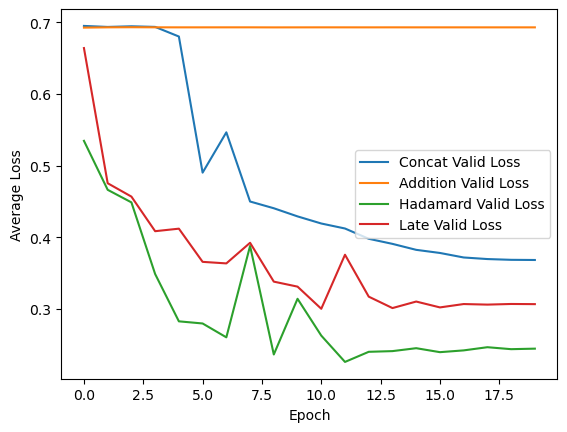

In [11]:
visualization.plot_loss(EPOCHS,
    {
        "Concat Valid Loss": cat_val_loss,
        "Addition Valid Loss": add_val_loss,
        "Hadamard Valid Loss": had_val_loss,
        "Late Valid Loss": late_val_loss
    }
)

## Analysis